# BERT 기반 한국어 감성 분석

## 1. bert-base-multilingual-cased
    * transformers 의 Bert tokenzier, Bert for sequence classification
    * 도서 "딥 러닝을 통한 자연어 처리 입문" 참고

## 2. KoBERT
    * SKTBrain 팀이 개발한 Bert 모델 기반 한국어 성능 향상
    * Model 내부 및 예측 흐름 확인
    
## 3. Conclusion
    * 임의의 input 문장이 들어왔을 때 긍정/부정 판별
    * 두 개의 모델 Accuracy 비교
    * 학습 내용 시각화

### import modules 

In [1]:
# import modules
import datetime
import time
import random

# for data analyze and wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request
from tqdm import tqdm, notebook


# machine learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
import gluonnlp as nlp


# kobert
from kobert_tokenizer import KoBERTTokenizer


In [2]:
# import dataset
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train = pd.read_table("ratings_train.txt", usecols = ['document','label'])
test = pd.read_table("ratings_test.txt", usecols = ['document','label'])

print(f'numbers of train data: {len(train)}')
print(f'numbers of test data: {len(test)}')
train.head(2)

numbers of train data: 150000
numbers of test data: 50000


,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1


### Data preprocessing

In [3]:
# train data preprocessing
# CLS : classifier
# SEP : separator
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'] = train['document'].str.replace('^ +', "")
train['document'].replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')

# before tokenizing
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train['document']]

# tokenizing
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(f"tokeinzed text : {tokenized_texts[0]}")

# padding
MAX_LEN = max([len(s) for s in tokenized_texts]) + 1
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

# attention mask
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# split train and validation set   
train_inputs, validation_inputs, train_labels, validation_labels = \
    train_test_split(input_ids, train['label'].values, random_state=42, test_size=0.1)

# attention mask for train and validation set
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.1)

# convert to tensor
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

# data loader
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
                        train_data, # which is converted to a TensorDataset
                        sampler=train_sampler, # reason of no shuffle is that we need to use validation set
                        batch_size=BATCH_SIZE,
                        pin_memory=True, # GPU memory
                        num_workers=4, # for parallel processing
                        )

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(
                        validation_data,
                        sampler=validation_sampler, 
                        batch_size=BATCH_SIZE,
                        pin_memory=True,
                        num_workers=4,
                        )

<ipython-input-3-4a98031647ec>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-3-4a98031647ec>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace('^ +', "")


tokeinzed text : ['[CLS]', '아', '더', '##빙', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


In [4]:
# test data preprocessing

test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'] = test['document'].str.replace('^ +', "")
test['document'].replace('', np.nan, inplace=True)
test = test.dropna(how = 'any')

sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in test['document']]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(
                    test_data, # which is converted to a TensorDataset
                    sampler=test_sampler, # reason of no shuffle is that we need to use validation set
                    batch_size=BATCH_SIZE,
                    pin_memory=True, # GPU memory
                    num_workers=4, # for parallel processing
                    )

<ipython-input-4-df121774fae7>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-4-df121774fae7>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace('^ +', "")


### GPU check (cuda)

In [5]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM3-32GB


## 1. bert-base-multilingual-cased

    * transformers 의 Bert tokenzier, Bert for sequence classification
    * 도서 "딥 러닝을 통한 자연어 처리 입문" 참고했고, 커스터마이징을 진행했습니다.
    * 코드 내부적으로 흐름을 파악하기 위해 Arguments를 바꿔가며 실험했습니다.

In [6]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
# loss function and optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # Learning rate
                  eps = 1e-8 # Epsilon for AdamW to avoid numerical issues (zero division)
                )

# number of training epochs
epochs = 5

# loss function to calculate loss
loss_fn = nn.CrossEntropyLoss()

# total number of training step 
# len(train_dataloader) : number of batches
total_steps = len(train_dataloader) * epochs

warmup_ratio = 0.1
warmup_step = int(total_steps * warmup_ratio)

# scheduler to decrease learning rate
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_step,
                                            num_training_steps = total_steps)

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# time format
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # change to hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [9]:
train_loss_bert_multilingual_cased_per_epoch = []
validation_accuracy_bert_multilingual_cased_per_epoch = []

In [10]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# zero gradients
model.zero_grad()

# loop over epochs
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # set time recorder
    t0 = time.time()

    # intialize the loss
    total_loss = 0

    # set model to train mode
    model.train()
        
    # get step and batch from train_dataloader
    for step, batch in enumerate(train_dataloader):
        # progress bar
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass                
        # **batch
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # get loss
        loss = outputs[0]

        # get the total loss
        total_loss += loss.item()

        # Backward pass, gradient calculation
        loss.backward()

        # gradient clipping to avoid gradient exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update weight parameters from backpropagation
        optimizer.step()

        # learning rate decay by scheduler
        scheduler.step()

        # zero gradients
        model.zero_grad()
        
    # evaluate the average loss over the epoch
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    train_loss_bert_multilingual_cased_per_epoch.append(avg_train_loss)
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    # set time recorder
    t0 = time.time()

    # set model to eval mode
    model.eval()

    # initialize the loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # get batch from val_dataloader
    for batch in validation_dataloader:
        # batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # no need to calculate gradients because of eval mode, so set requires_grad to False
        with torch.no_grad():     
            # Forward pass
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # get loss
        logits = outputs[0]

        # loss to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # calculate evaluation accuracy
        # flat_accuracy : calculate accuracy of each batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    validation_accuracy_bert_multilingual_cased_per_epoch.append(eval_accuracy/nb_eval_steps)

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch   500  of  4,184.    Elapsed: 0:01:47.
  Batch 1,000  of  4,184.    Elapsed: 0:03:33.
  Batch 1,500  of  4,184.    Elapsed: 0:05:19.
  Batch 2,000  of  4,184.    Elapsed: 0:07:04.
  Batch 2,500  of  4,184.    Elapsed: 0:08:50.
  Batch 3,000  of  4,184.    Elapsed: 0:10:36.
  Batch 3,500  of  4,184.    Elapsed: 0:12:21.
  Batch 4,000  of  4,184.    Elapsed: 0:14:07.

  Average training loss: 0.45
  Training epcoh took: 0:14:46

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:30

======== Epoch 2 / 5 ========
Training...
  Batch   500  of  4,184.    Elapsed: 0:01:46.
  Batch 1,000  of  4,184.    Elapsed: 0:03:32.
  Batch 1,500  of  4,184.    Elapsed: 0:05:18.
  Batch 2,000  of  4,184.    Elapsed: 0:07:04.
  Batch 2,500  of  4,184.    Elapsed: 0:08:49.
  Batch 3,000  of  4,184.    Elapsed: 0:10:35.
  Batch 3,500  of  4,184.    Elapsed: 0:12:21.
  Batch 4,000  of  4,184.    Elapsed: 0:14:07.

  Average training loss: 0.36
  

In [12]:
t0 = time.time()

model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))
bert_base_multilingual_cased_accuracy = eval_accuracy/nb_eval_steps

  Batch   100  of  1,550.    Elapsed: 0:00:07.
  Batch   200  of  1,550.    Elapsed: 0:00:13.
  Batch   300  of  1,550.    Elapsed: 0:00:19.
  Batch   400  of  1,550.    Elapsed: 0:00:26.
  Batch   500  of  1,550.    Elapsed: 0:00:32.
  Batch   600  of  1,550.    Elapsed: 0:00:38.
  Batch   700  of  1,550.    Elapsed: 0:00:45.
  Batch   800  of  1,550.    Elapsed: 0:00:51.
  Batch   900  of  1,550.    Elapsed: 0:00:57.
  Batch 1,000  of  1,550.    Elapsed: 0:01:04.
  Batch 1,100  of  1,550.    Elapsed: 0:01:10.
  Batch 1,200  of  1,550.    Elapsed: 0:01:16.
  Batch 1,300  of  1,550.    Elapsed: 0:01:23.
  Batch 1,400  of  1,550.    Elapsed: 0:01:29.
  Batch 1,500  of  1,550.    Elapsed: 0:01:36.

Accuracy: 0.86
Test took: 0:01:39


## 2. KoBERT

```
predefined_args = {
        'attention_cell': 'multi_head',
        'num_layers': 12,
        'units': 768,
        'hidden_size': 3072,
        'max_length': 512,
        'num_heads': 12,
        'scaled': True,
        'dropout': 0.1,
        'use_residual': True,
        'embed_size': 768,
        'embed_dropout': 0.1,
        'token_type_vocab_size': 2,
        'word_embed': None,
    }
```

    * SKTBrain github에 제공된 notebook을 토대로 커스터마이징을 진행했습니다.
    * Model 내부 및 예측 흐름 확인

In [13]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [14]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [15]:
dataset_train = nlp.data.TSVDataset("ratings_train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("ratings_test.txt", field_indices=[1,2], num_discard_samples=1)

In [16]:
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, 64, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, 64, True, False)

train_dataloader = DataLoader(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    num_workers=4,
                    shuffle=True,
                    pin_memory=True
                    )
test_dataloader = DataLoader(
                    data_test, 
                    batch_size=BATCH_SIZE, 
                    num_workers=4,
                    shuffle=True,
                    pin_memory=True
                    )

In [17]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
    
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [18]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # Learning rate
                  eps = 1e-8 # Epsilon for AdamW to avoid numerical issues (zero division)
                )

loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * epochs
warmup_step = int(t_total * 0.1)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [19]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [20]:
train_loss_kobert_per_epoch = []
train_accuracy_kobert_per_epoch = []

In [21]:
for e in range(epochs):

    train_acc = 0.0
    test_acc = 0.0

    model.train()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):

        optimizer.zero_grad()

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        if batch_id % 200 == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_loss_kobert_per_epoch.append(loss.data.cpu().numpy())
    train_accuracy_kobert_per_epoch.append(train_acc / (batch_id+1))

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    
    kobert_accuracy = test_acc / (batch_id+1)

  0%|          | 0/4688 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.6896642446517944 train acc 0.53125
epoch 1 batch id 201 loss 0.7195993661880493 train acc 0.505752487562189
epoch 1 batch id 401 loss 0.6234786510467529 train acc 0.5455112219451371
epoch 1 batch id 601 loss 0.5720820426940918 train acc 0.6271318635607321
epoch 1 batch id 801 loss 0.3160232603549957 train acc 0.6730649188514357
epoch 1 batch id 1001 loss 0.10534768551588058 train acc 0.7058566433566433
epoch 1 batch id 1201 loss 0.267437607049942 train acc 0.7297304329725229
epoch 1 batch id 1401 loss 0.30100053548812866 train acc 0.746743397573162
epoch 1 batch id 1601 loss 0.3154330551624298 train acc 0.7599742348532167
epoch 1 batch id 1801 loss 0.412508100271225 train acc 0.7697112715158245
epoch 1 batch id 2001 loss 0.302864670753479 train acc 0.7779079210394803
epoch 1 batch id 2201 loss 0.2663799524307251 train acc 0.7854668332576101
epoch 1 batch id 2401 loss 0.4452560245990753 train acc 0.7913759891711787
epoch 1 batch id 2601 loss 0.4079663157463074 

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 1 test acc 0.8821377159309021


  0%|          | 0/4688 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.21942779421806335 train acc 0.9375
epoch 2 batch id 201 loss 0.16053864359855652 train acc 0.900497512437811
epoch 2 batch id 401 loss 0.3911174535751343 train acc 0.9011845386533666
epoch 2 batch id 601 loss 0.35175397992134094 train acc 0.8999584026622296
epoch 2 batch id 801 loss 0.28481703996658325 train acc 0.8999687890137328
epoch 2 batch id 1001 loss 0.16768449544906616 train acc 0.9002872127872128
epoch 2 batch id 1201 loss 0.1901545226573944 train acc 0.9003955037468776
epoch 2 batch id 1401 loss 0.23256605863571167 train acc 0.9000267665952891
epoch 2 batch id 1601 loss 0.3452270030975342 train acc 0.8995354465958776
epoch 2 batch id 1801 loss 0.4288899898529053 train acc 0.8993441143808995
epoch 2 batch id 2001 loss 0.17774713039398193 train acc 0.8987849825087456
epoch 2 batch id 2201 loss 0.18110235035419464 train acc 0.8986398228078146
epoch 2 batch id 2401 loss 0.24248681962490082 train acc 0.898362661391087
epoch 2 batch id 2601 loss 0.07240406

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 2 test acc 0.8859365003198977


  0%|          | 0/4688 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.22292691469192505 train acc 0.90625
epoch 3 batch id 201 loss 0.1691727191209793 train acc 0.9353233830845771
epoch 3 batch id 401 loss 0.10388654470443726 train acc 0.9339931421446384
epoch 3 batch id 601 loss 0.1604059934616089 train acc 0.9337562396006656
epoch 3 batch id 801 loss 0.3961453139781952 train acc 0.9325452559300874
epoch 3 batch id 1001 loss 0.13517558574676514 train acc 0.9330669330669331
epoch 3 batch id 1201 loss 0.34183600544929504 train acc 0.933544962531224
epoch 3 batch id 1401 loss 0.1607390195131302 train acc 0.9331727337615988
epoch 3 batch id 1601 loss 0.26959913969039917 train acc 0.9328739850093691
epoch 3 batch id 1801 loss 0.24328456819057465 train acc 0.9331100777345919
epoch 3 batch id 2001 loss 0.11234334856271744 train acc 0.9340798350824587
epoch 3 batch id 2201 loss 0.07256606966257095 train acc 0.9343764198091776
epoch 3 batch id 2401 loss 0.1881340742111206 train acc 0.9346886713869221
epoch 3 batch id 2601 loss 0.0512766

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 3 test acc 0.8966530710172744


  0%|          | 0/4688 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.018985044211149216 train acc 1.0
epoch 4 batch id 201 loss 0.17662766575813293 train acc 0.9682835820895522
epoch 4 batch id 401 loss 0.20021408796310425 train acc 0.9659445137157108
epoch 4 batch id 601 loss 0.0823211818933487 train acc 0.9645902662229617
epoch 4 batch id 801 loss 0.04671482369303703 train acc 0.9651217228464419
epoch 4 batch id 1001 loss 0.19085052609443665 train acc 0.9654408091908092
epoch 4 batch id 1201 loss 0.2113514393568039 train acc 0.9657316819317235
epoch 4 batch id 1401 loss 0.04337078332901001 train acc 0.9655380085653105
epoch 4 batch id 1601 loss 0.06009234860539436 train acc 0.9651584946908183
epoch 4 batch id 1801 loss 0.176896333694458 train acc 0.9652970571904498
epoch 4 batch id 2001 loss 0.11116272211074829 train acc 0.9651268115942029
epoch 4 batch id 2201 loss 0.2176637202501297 train acc 0.9652430713312131
epoch 4 batch id 2401 loss 0.0855502039194107 train acc 0.9655221782590587
epoch 4 batch id 2601 loss 0.0671638250

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 4 test acc 0.8983925143953935


  0%|          | 0/4688 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.01645178347826004 train acc 1.0
epoch 5 batch id 201 loss 0.08279287815093994 train acc 0.9849191542288557
epoch 5 batch id 401 loss 0.008490854874253273 train acc 0.982465710723192
epoch 5 batch id 601 loss 0.12317541241645813 train acc 0.9823731281198004
epoch 5 batch id 801 loss 0.0051270113326609135 train acc 0.9822877652933832
epoch 5 batch id 1001 loss 0.003696909872815013 train acc 0.9826111388611388
epoch 5 batch id 1201 loss 0.16133549809455872 train acc 0.9824104912572856
epoch 5 batch id 1401 loss 0.00849701277911663 train acc 0.9822002141327623
epoch 5 batch id 1601 loss 0.0047793020494282246 train acc 0.982237663960025
epoch 5 batch id 1801 loss 0.18387871980667114 train acc 0.9821973903387007
epoch 5 batch id 2001 loss 0.2534700334072113 train acc 0.9820246126936532
epoch 5 batch id 2201 loss 0.011350002139806747 train acc 0.9819542253521126
epoch 5 batch id 2401 loss 0.026777297258377075 train acc 0.9817914410662224
epoch 5 batch id 2601 loss 0.

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 5 test acc 0.896853007037748


## 3. Conclusion
    * 임의의 input 문장이 들어왔을 때 긍정/부정 판별
    * 두 개의 모델 Accuracy 비교
    * 학습 내용 시각화

In [22]:
# text classification with KoBert
def predict_input_text(text):
    transform = nlp.data.BERTSentenceTransform(
                tokenizer.tokenize, max_seq_length=128, vocab=vocab, pad=True, pair=False)

    sentence = text
    sentence = transform([sentence])

    sentence_dataloader = DataLoader(sentence, batch_size=1, shuffle=False)

    token_ids, valid_length, segment_ids = sentence_dataloader
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length

    out = model(token_ids, valid_length, segment_ids)
    predict = torch.max(out, 1)[1].item()
    if predict == 0:
        return "부정적인 문장입니다"
    else:
        return "긍정적인 문장입니다"

    

In [23]:
predict_input_text('이건 좀... 아니지 않니..?')

'부정적인 문장입니다'

In [24]:
print(f"bert_base_multilingual_cased_accuracy : {bert_base_multilingual_cased_accuracy}")
print(f"kobert_accuracy : {kobert_accuracy}")

bert_base_multilingual_cased_accuracy : 0.8555933179723503
kobert_accuracy : 0.896853007037748


<AxesSubplot:>

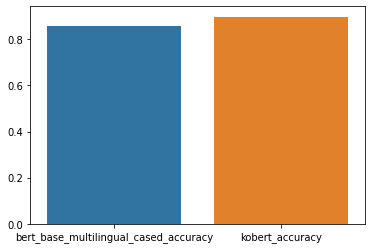

In [25]:
sns.barplot(x=['bert_base_multilingual_cased_accuracy', 'kobert_accuracy'], y=[bert_base_multilingual_cased_accuracy, kobert_accuracy])

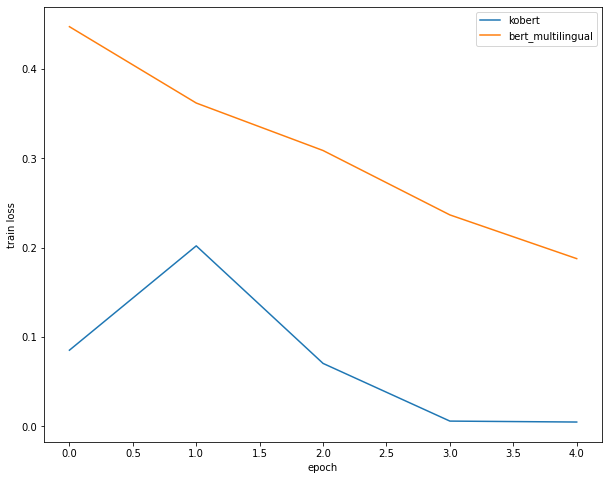

In [26]:
# visualize the loss bert_multilingual and kobert
plt.figure(figsize=(10,8))
plt.plot(range(epochs), train_loss_kobert_per_epoch, label='kobert')
plt.plot(range(epochs), train_loss_bert_multilingual_cased_per_epoch, label='bert_multilingual')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

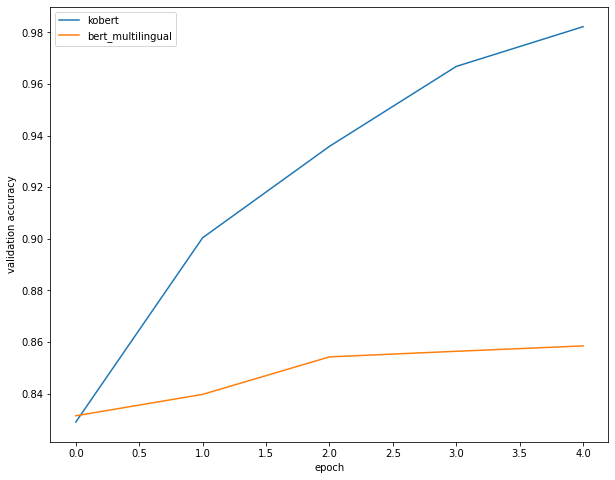

In [27]:
# visualize the accuracy bert_multilingual and kobert
plt.figure(figsize=(10,8))
plt.plot(range(epochs), train_accuracy_kobert_per_epoch, label='kobert')
plt.plot(range(epochs), validation_accuracy_bert_multilingual_cased_per_epoch, label='bert_multilingual')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.show()